# Vehicle Detection
This notebook allows a trained model to be loaded into a detection class which then operates over an image (static or video) to identify vehicles

In [1]:
# imports
import feature_extraction as fe
import lane_detector as ld
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage.measurements import label
import glob
from moviepy.editor import VideoFileClip
import collections
%matplotlib inline

In [30]:
class vehicle_detector:
    
    def __init__(self, params=None, model=None, scaler = None, scales=[0.5, 1.5], crop=(400,656), 
                 mode='single', threshold=1, frames=5, add_lanes=False):
        self.extraction_params = params
        self.model = model
        self.scaler = scaler
        self.scales = scales
        self.crop = crop
        self.mode = mode
        self.color_list = color_list = {
            'RGB': cv2.COLOR_BGR2RGB,
            'HSV': cv2.COLOR_BGR2HSV,
            'LUV': cv2.COLOR_BGR2LUV,
            'HLS': cv2.COLOR_BGR2HLS,
            'YUV': cv2.COLOR_BGR2YUV,
            'YCrCb': cv2.COLOR_BGR2YCrCb
        }
        self.average_over_frames = frames
        self.detected_windows = collections.deque(maxlen=self.average_over_frames)
        self.window_threshold = threshold
        
        # calibrate the camera
        self.IMG_DIR = 'camera_cal/'
        self.calibration_files = glob.glob(self.IMG_DIR+"*.jpg")
        self.NX = 9
        self.NY = 6
        self.add_lanes = add_lanes
        
        if self.add_lanes: 
            self.testobj, self.testimg = ld.calibrate_camera(self.calibration_files, self.NX, self.NY)
            print('camera calibrated')
            
        # threshold defaults
        self.ksize = 9
        self.sobel_thresh = (50, 150)
        self.direction_thresh =  (0.7, 1.3)
        self.color_thresh = (150, 255)
        
        # track lanes need to be sought and track last n things...always start by seeking
        self.seek_lanes = True
        self.average_over_frames = 5
        self.bad_frames = 0
        self.left_fit_list = collections.deque(maxlen=self.average_over_frames)
        self.right_fit_list = collections.deque(maxlen=self.average_over_frames)
        self.left_curve_list = collections.deque(maxlen=self.average_over_frames)
        self.right_curve_list = collections.deque(maxlen=self.average_over_frames)
        self.lane_offset_list = collections.deque(maxlen=self.average_over_frames)
        self.best_left_fit = []
        self.best_right_fit = []
        self.best_left_curve = 0
        self.best_right_curve = 0
        self.best_lane_offset = 0
            
    def append_lists(self,left_fit, right_fit, left_curve, right_curve, offset):
        self.left_fit_list.append(left_fit)
        self.best_left_fit = np.mean(self.left_fit_list, axis=0)

        self.right_fit_list.append(right_fit)
        self.best_right_fit = np.mean(self.right_fit_list, axis=0)

        self.left_curve_list.append(left_curve)
        self.best_left_curve = np.mean(self.left_curve_list)

        self.right_curve_list.append(right_curve)
        self.best_right_curve = np.mean(self.right_curve_list)

        self.lane_offset_list.append(offset)
        self.best_lane_offset = np.mean(self.lane_offset_list)

    def check_lane_sanity(self, left_fit, right_fit,
                               left_curve, right_curve, offset):
        # check the goodness of fit of the new line
        # is the left_fit close to the current left_fit?
        left_test = np.absolute(np.subtract(left_fit[2], self.best_left_fit[2]))
        right_test = np.absolute(np.subtract(right_fit[2], self.best_right_fit[2]))
        left_curve_test = np.absolute(np.subtract(left_curve, self.best_left_curve))
        right_curve_test = np.absolute(np.subtract(right_curve, self.best_right_curve))
        offset_test = np.absolute(np.subtract(offset, self.best_lane_offset))
        if (left_test > 75 or right_test > 75):
            # we have a bad frame
            self.bad_frames += 1
            if self.bad_frames == 7:
                # make us search afresh next time and reset bad lanes
                self.seek_lanes = True
                self.bad_frames = 0
            return 0
        else:
            self.bad_frames = 0
            return -1

    def get_plot_lines(self, img):
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = self.best_left_fit[0]*ploty**2 + self.best_left_fit[1]*ploty + self.best_left_fit[2]
        right_fitx = self.best_right_fit[0]*ploty**2 + self.best_right_fit[1]*ploty + self.best_right_fit[2]
        return (ploty, left_fitx, right_fitx)
    
    def initialise_image(self, img, scale):
        """
            function to normalise, color convert and crop the image
            Args:
                img: the image to initialise
            Returns:
                search_img: the processed image
        """        
        # crop
        search_img = img[self.crop[0]:self.crop[1],:,:]
        
        # color_convert
        conversion = self.color_list[self.extraction_params['color_space']]
        search_img = cv2.cvtColor(search_img, conversion)

        # scale image
        if scale != 1:
            imshape = search_img.shape
            search_img = cv2.resize(search_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        search_img = search_img.astype(np.float32)/255

        return search_img
        
    def get_all_hog_features(self, search_img):
        """
            function to generate all hog features for the image
            Args:
                search_img: the image to generate
            Returns:
                hog1, hog2, hog3: the features for each channel
        """
        
        # Compute individual channel HOG features for the entire image
        hog1 = fe.get_hog_features(search_img[:,:,0], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        hog2 = fe.get_hog_features(search_img[:,:,1], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        hog3 = fe.get_hog_features(search_img[:,:,2], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        return hog1, hog2, hog3
    
    def run_windows(self, search_img, draw_img, hog1, hog2, hog3, scale):
        """
            function to run the sliding window search and return an image with detected vehicles
            Args:
                search_img: the image to search
                draw_img: the image to draw on
                hog1, hog2, hog3: the hog features for the entire image
            Returns
                draw_img: the image with the boxes drawn on
        """
        
        # reset the detected windows array for current frame
        self.detected_window_frame = []
        
        # Define blocks and steps as above
        nxblocks = (search_img.shape[1] // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1
        nyblocks = (search_img.shape[0] // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1 
        nfeat_per_block = self.extraction_params['orient']*self.extraction_params['cell_per_block']**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
            
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*self.extraction_params['pix_per_cell']
                ytop = ypos*self.extraction_params['pix_per_cell']

                # Extract the image patch
                subimg = cv2.resize(search_img[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = fe.bin_spatial(subimg, size=self.extraction_params['spatial_size'])
                hist_features = fe.color_hist(subimg, nbins=self.extraction_params['hist_bins'])
            
                # Scale features and make a prediction
                test_features = self.scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = self.model.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+self.crop[0]),
                                  (xbox_left+win_draw,ytop_draw+win_draw+self.crop[0]),(0,0,255),6) 
                    self.detected_window_frame.append([(xbox_left, ytop_draw+self.crop[0]), 
                                                  (xbox_left+win_draw,ytop_draw+win_draw+self.crop[0])])
                    
                if len(self.detected_window_frame) > 0:
                    self.detected_windows.append(self.detected_window_frame)
                    
        return draw_img

    def add_heat_and_threshold(self, heatmap, threshold):
        """
            function creating a heatmap
            
        """
        # Iterate through list of bboxes
        for frame in self.detected_windows:
            for box in frame:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        heatmap[heatmap <= threshold] = 0
        
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        """
            function drawing bounding boxes onto the image
            Args:
                img: base image to draw onto
                labels: the boxes to draw
            Returns
                draw_img: the image with the boxes
        """
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        # Return the image
        return img
    
    def process_image(self, img):
        """
            function to apply detection technique to image
            Args:
                img: the image to operate on
                mode: 
                    'single' will draw various outputs and return an image with detected vehicles
                    'video' will just output the detected vehicle images
            Returns:
                draw_img: the image with bounding boxes showing the images detected
        """
        
        if self.mode == 'single':
            find_img = np.copy(img)
            img = cv2.cvtColor(np.copy(img), cv2.COLOR_BGR2RGB)
        else:
            find_img = cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2BGR)
            
        draw_img = np.copy(find_img)
        # for for all scale values:
        for scale in self.scales:
            # get the image to search over
            search_img = self.initialise_image(find_img, scale)
    
            # get hog for all image
            hog1, hog2, hog3 = self.get_all_hog_features(search_img)
        
            # run the sliding window and prediction...
            win_img = self.run_windows(search_img, draw_img, hog1, hog2, hog3, scale)
        
        # Add heat to each box in box list
        heat = self.add_heat_and_threshold(np.zeros_like(img[:,:,0]).astype(np.float), self.window_threshold)
    
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        # color_convert
        draw_img = self.draw_labeled_bboxes(img, labels)
            
        if self.add_lanes:
            # get the binary threshold across sobel_absx and hsv on an undistorted image
            undistort = ld.img_undistort(img, self.testobj, self.testimg)
            cbinary = ld.get_gradhls_combined(undistort, self.sobel_thresh, self.color_thresh)
            transformed = ld.apply_perspective_transform(cbinary)
            histogram = ld.return_histogram(transformed)

            # do we need to seek? will use last 1 to begin with
            if self.seek_lanes:
                left_fit, right_fit, left_fitx, right_fitx, ploty, left_curve, right_curve, offset = ld.seek_lanes(transformed,
                                                                                                                histogram)
                self.seek_lanes = False
                sane_line = -1
            else:
                left_fit, right_fit, left_fitx, right_fitx, ploty, left_curve, right_curve, offset = ld.find_lanes(transformed,
                                                                                                                self.left_fit_list[-1],
                                                                                                                self.right_fit_list[-1])
                sane_line = self.check_lane_sanity(left_fit, right_fit,
                                                   left_curve, right_curve, offset)

            if sane_line == -1:
                # if -1 ok to append line
                self.append_lists(left_fit, right_fit,
                                  left_curve, right_curve, offset)

            lines_to_plot = self.get_plot_lines(transformed)

            draw_img = ld.draw_output(draw_img, transformed,
                                  lines_to_plot[1],
                                  lines_to_plot[2],
                                  lines_to_plot[0],
                                  self.best_left_curve,
                                  self.best_right_curve,
                                  self.best_lane_offset,
                                  self.bad_frames)
        
        if self.mode == 'single':
            return draw_img, heatmap, win_img, search_img   
        else:
            return draw_img

In [31]:
filename = 'model.pkl'
pkl_file = open(filename, 'rb')

data1 = pickle.load(pkl_file)
model = data1['model']
scaler = data1['scaler']
pkl_file.close()

filename = 'extraction_features.pkl'
features_file = open(filename, 'rb')

features = pickle.load(features_file)
features_file.close()

detector = vehicle_detector(features, model, scaler, add_lanes=True)

camera calibrated


In [32]:
img = cv2.imread('test_images/test1.jpg')
draw_img, heatmap, win_img, search_img = detector.process_image(img)

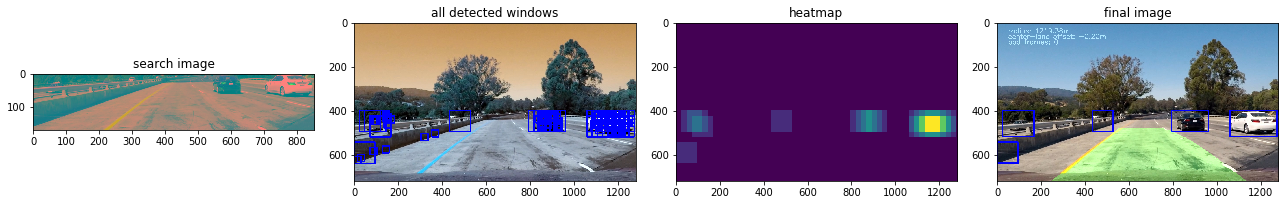

In [33]:
def print_img(imgs=None):
    """
        helper to print images
        Args:
            imgs: array expecting img and title tuples
    """
    if imgs:
        c = len(imgs)
        fig, ax = plt.subplots(1, c, figsize=(18,6))
        i = 0
        for img in imgs:
            ax[i].set_title(img[1])
            ax[i].imshow(img[0])
            i += 1
    
        plt.tight_layout()
        plt.show()

img_list = [
    [search_img, 'search image'],
    [win_img, 'all detected windows'],
    [heatmap, 'heatmap'],
    [draw_img, 'final image']
]
print_img(img_list)

camera calibrated


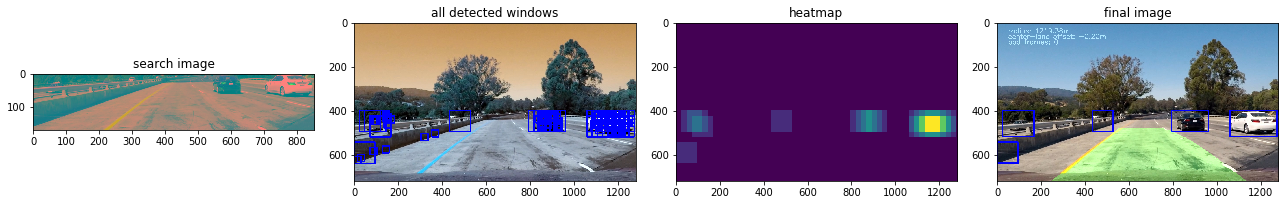

camera calibrated


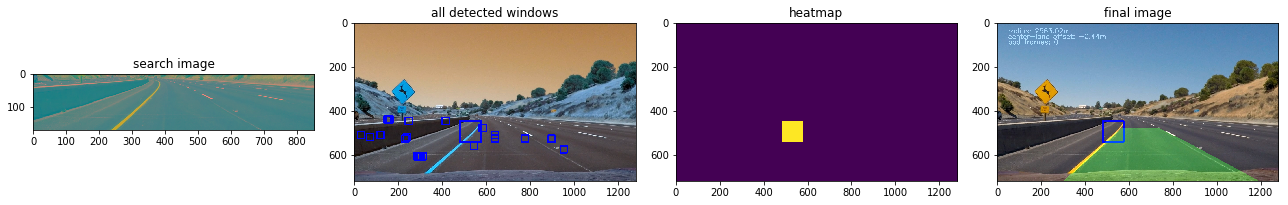

camera calibrated


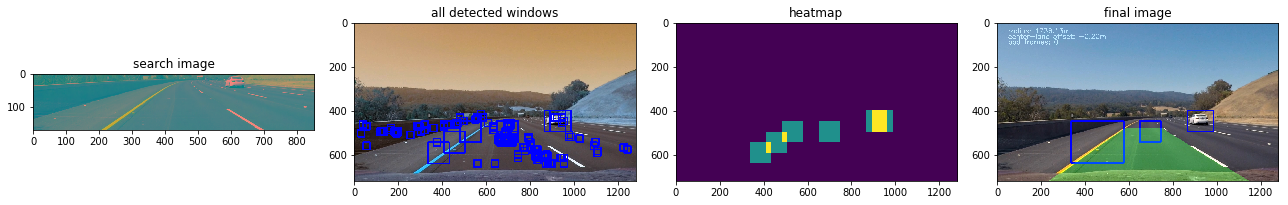

camera calibrated


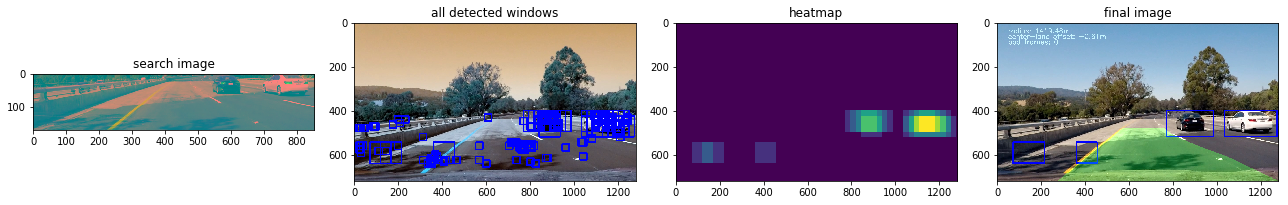

camera calibrated


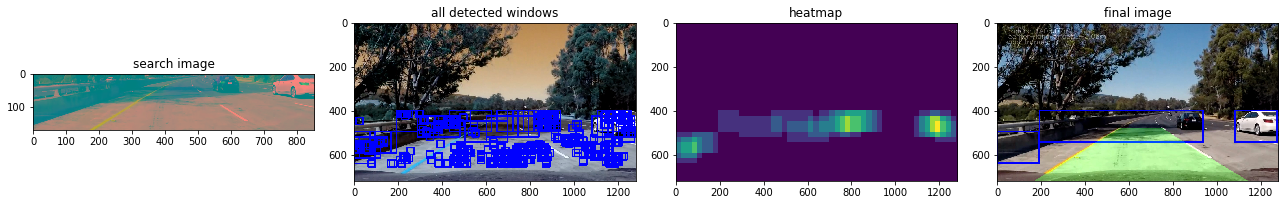

camera calibrated


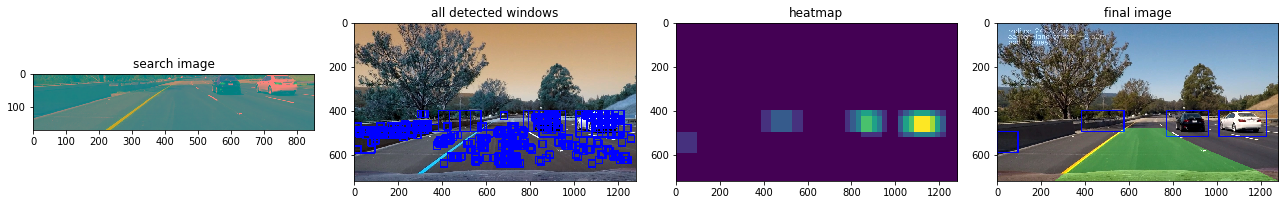

In [34]:
# let's do the test images...
imgs = glob.glob('test_images/*.jpg', recursive=True)
for img in imgs:
    detector = vehicle_detector(features, model, scaler, add_lanes=True)
    img = cv2.imread(img)
    draw_img, heatmap, win_img, search_img = detector.process_image(img)
    img_list = [
        [search_img, 'search image'],
        [win_img, 'all detected windows'],
        [heatmap, 'heatmap'],
        [draw_img, 'final image']
    ]
    print_img(img_list)

### Video Stream

In [36]:
detector = vehicle_detector(features, model, scaler, mode='video', threshold=20, frames=5, add_lanes=True)
output = 'project_video_output.mp4'
##output = 'output_videos/challenge1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
input_clip = VideoFileClip("project_video.mp4").subclip(7,15)
##input_clip = VideoFileClip("project_video.mp4")
##input_clip = VideoFileClip("test_video.mp4")
##clip1 = VideoFileClip("input_videos/challenge_video.mp4")
###clip1 = VideoFileClip("input_videos/harder_challenge_video.mp4")
output_clip = input_clip.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)
input_clip.reader.close()
input_clip.audio.reader.close_proc()
output_clip.reader.close()
output_clip.audio.reader.close_proc()

camera calibrated
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 200/201 [26:23<00:11, 11.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 26min 26s


In [ ]:
print(detector.detected_windows)